In [61]:
import numpy as np
import matplotlib 
import matplotlib as mpl
from astropy.stats import LombScargle
from astropy.stats import sigma_clip
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from astropy.io import fits
import h5py

import halophot
from halophot.halo_tools import halo_tpf
import lightkurve 
from lightkurve import TessTargetPixelFile, TessLightCurveFile, TessLightCurve
from lightkurve.utils import plot_image

from lightkurve import MPLSTYLE

print(halophot.__version__)

0.6.6.2


In [2]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=22              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

Populating the interactive namespace from numpy and matplotlib


In [3]:
fname = '../data/tess2018206045859-s0001-0000000029281992-0120-s_tp.fits.gz' #omega Capricorni

In [4]:
tpf = lightkurve.open(fname)

In [5]:
tpf.interact()

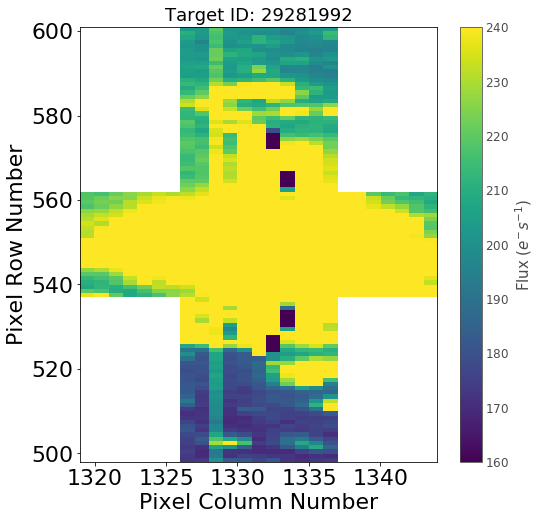

In [172]:
fig, ax = plt.subplots(figsize=(8,8))
tpf.plot(ax = ax, bkg=True, cadenceno=84023, scale='linear',vmin=160,vmax=240,aspect='auto')
plt.show()

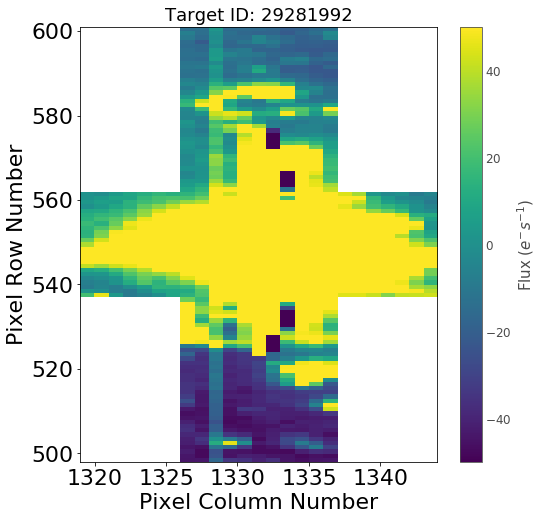

In [174]:
fig, ax = plt.subplots(figsize=(8,8))
tpf.plot(ax = ax, bkg=False, cadenceno=84023, scale='linear',vmin=-50,vmax=50,aspect='auto')
plt.show()

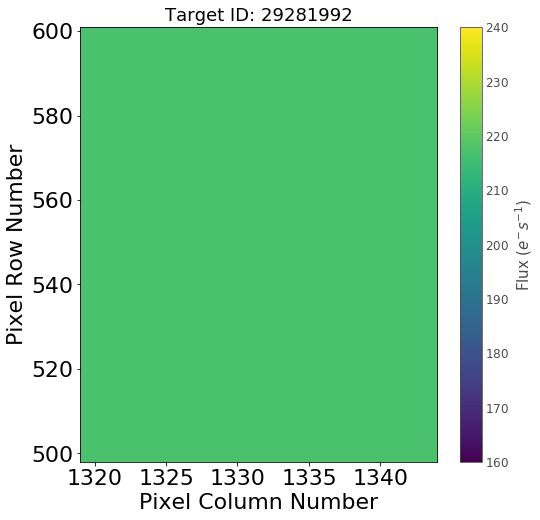

In [171]:
fig, ax = plt.subplots(figsize=(8,8))
plot_bkg(tpf,ax = ax, cadenceno=84023, scale='linear',vmin=160,vmax=240,aspect='auto')
plt.show()

In [83]:
print(tpf.column)
print(tpf.column + tpf.shape[2])
print(tpf.row)
print(tpf.row + tpf.shape[1])

tpfcut = (tpf.row,tpf.row+tpf.shape[1],tpf.column,tpf.column+tpf.shape[2])

1319
1344
498
601


In [8]:
def plot_bkg(tpf,ax=None, frame=0, cadenceno=None, aperture_mask=None,
         show_colorbar=True, mask_color='pink', style='lightkurve', **kwargs):
    """Plot the pixel data for a single frame (i.e. at a single time).
    The time can be specified by frame index number (`frame=0` will show the
    first frame) or absolute cadence number (`cadenceno`).
    Parameters
    ----------
    ax : matplotlib.axes._subplots.AxesSubplot
        A matplotlib axes object to plot into. If no axes is provided,
        a new one will be generated.
    frame : int
        Frame number. The default is 0, i.e. the first frame.
    cadenceno : int, optional
        Alternatively, a cadence number can be provided.
        This argument has priority over frame number.
    bkg : bool
        If True, background will be added to the pixel values.
    aperture_mask : ndarray or str
        Highlight pixels selected by aperture_mask.
    show_colorbar : bool
        Whether or not to show the colorbar
    mask_color : str
        Color to show the aperture mask
    style : str
        Path or URL to a matplotlib style file, or name of one of
        matplotlib's built-in stylesheets (e.g. 'ggplot').
        Lightkurve's custom stylesheet is used by default.
    kwargs : dict
        Keywords arguments passed to `lightkurve.utils.plot_image`.
    Returns
    -------
    ax : matplotlib.axes._subplots.AxesSubplot
        The matplotlib axes object.
    """
    if style == 'lightkurve' or style is None:
        style = MPLSTYLE
    if cadenceno is not None:
        try:
            frame = np.argwhere(cadenceno == tpf.cadenceno)[0][0]
        except IndexError:
            raise ValueError("cadenceno {} is out of bounds, "
                             "must be in the range {}-{}.".format(
                                 cadenceno, tpf.cadenceno[0], tpf.cadenceno[-1]))
    try:
        if np.any(np.isfinite(tpf.flux_bkg[frame])):
            pflux = tpf.flux_bkg[frame]
    except IndexError:
        raise ValueError("frame {} is out of bounds, must be in the range "
                         "0-{}.".format(frame, tpf.shape[0]))
    with plt.style.context(style):
        img_title = 'Target ID: {}'.format(tpf.targetid)
        img_extent = (tpf.column, tpf.column + tpf.shape[2],
                      tpf.row, tpf.row + tpf.shape[1])
        ax = plot_image(pflux, ax=ax, title=img_title, extent=img_extent,
                        show_colorbar=show_colorbar, **kwargs)
        ax.grid(False)
    if aperture_mask is not None:
        aperture_mask = tpf._parse_aperture_mask(aperture_mask)
        for i in range(tpf.shape[1]):
            for j in range(tpf.shape[2]):
                if aperture_mask[i, j]:
                    ax.add_patch(patches.Rectangle((j+tpf.column, i+tpf.row),
                                                   1, 1, color=mask_color, fill=True,
                                                   alpha=.6))
    return ax

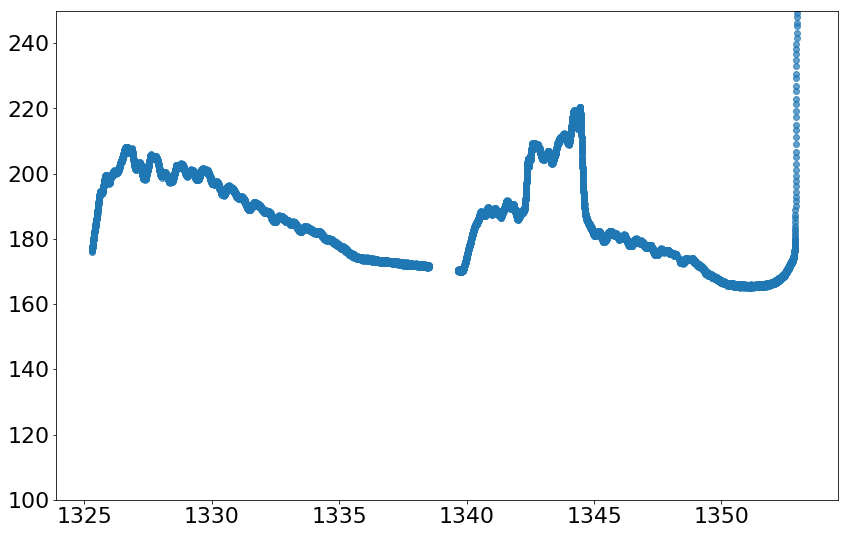

5582
1343.7665997359504


In [135]:
fig = plt.figure(figsize=(14,9))
oldbks = tpf.flux_bkg
plt.plot(tpf.time, oldbks[:,0,0],'o',alpha=0.7)

# plt.plot(s1c1ccd4['time'][()], bkgd[:,102,0],'o',alpha=0.7)

# plt.xlim(1340,1345)
plt.ylim(100,250)
# plt.axvline(1394.3)
# plt.axvline(1394.6)
plt.show()



print(s1c1ccd4['cadenceno'][()][830])

print(s1c1ccd4['time'][()][830])

In [12]:
s1c1ccd4 = h5py.File('../data/sector001_camera1_ccd4.hdf5','r')

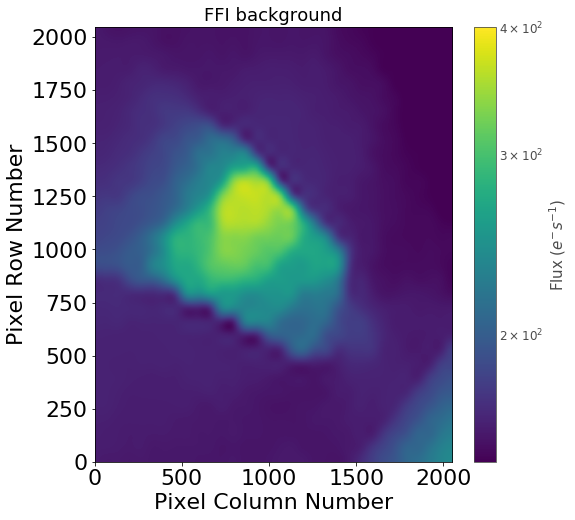

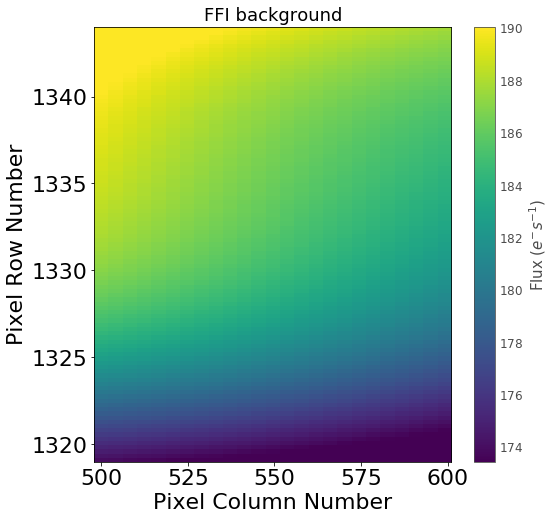

In [169]:
fig, ax = plt.subplots(figsize=(8,8))
plot_ffi_bkg(s1c1ccd4,ax = ax, cadenceno=5600,vmin=150,vmax=400, scale='log',aspect='auto')
plt.show()

fig, ax = plt.subplots(figsize=(8,8))
plot_ffi_bkg(s1c1ccd4,ax = ax, cadenceno=5600, cut = tpfcut, scale='linear',aspect='auto')
plt.show()

In [ ]:
cut = tpfcut

bkgd = s1c1ccd4['backgrounds']['0001'][()][cut[0]:cut[1],cut[2]:cut[3]]
bkgd = np.expand_dims(bkgd, axis=0)

for c in np.arange(1,cadences):
    bkgd = np.append(bkgd,np.expand_dims(s1c1ccd4['backgrounds']['{:04d}'.format(c)][()][cut[0]:cut[1],cut[2]:cut[3]],axis = 0),axis=0)
    
print(bkgd.shape)


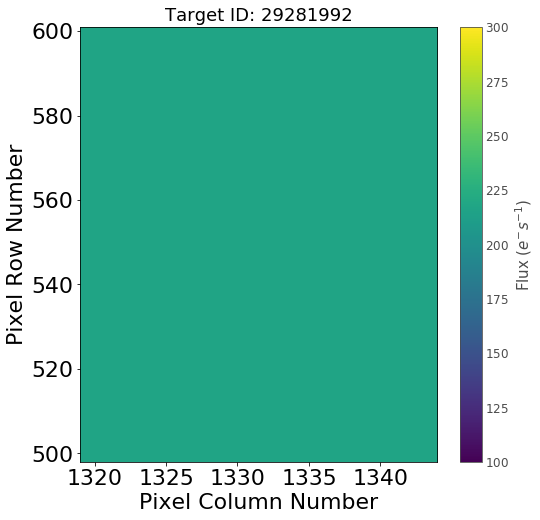

In [146]:
fig, ax = plt.subplots(figsize=(8,8))
plot_bkg(tpf,ax = ax, cadenceno=84023, scale='linear',vmin=100,vmax=300,aspect='auto')
plt.show()

In [86]:
bkspline = CubicSpline(s1c1ccd4['time'][()], bkgd)
newbks = bkspline(tpf.time)
print(newbks.shape)

# 


(18104, 103, 25)


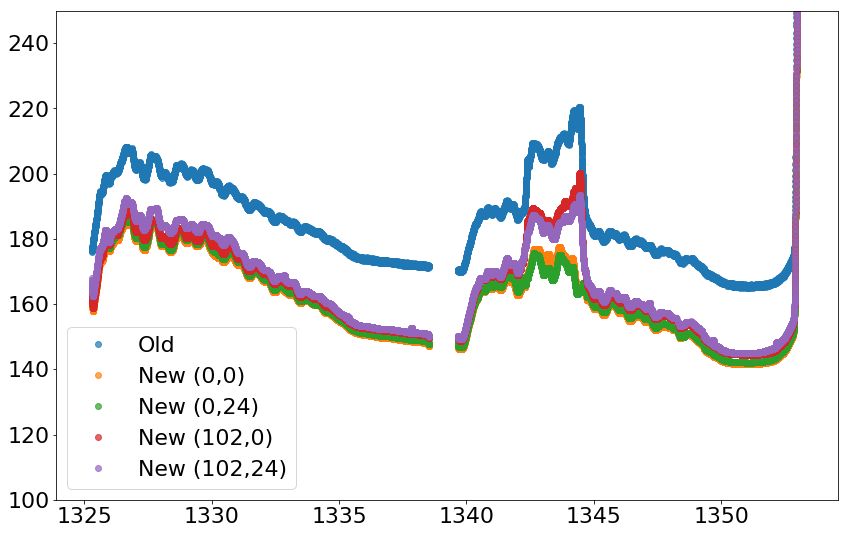

In [90]:
fig = plt.figure(figsize=(14,9))

plt.plot(tpf.time, oldbks[:,0,0],'o',alpha=0.7,label='Old')
plt.plot(tpf.time, newbks[:,0,0],'o',alpha=0.7,label='New (0,0)')
plt.plot(tpf.time, newbks[:,0,24],'o',alpha=0.7,label='New (0,24)')
plt.plot(tpf.time, newbks[:,102,0],'o',alpha=0.7,label='New (102,0)')
plt.plot(tpf.time, newbks[:,102,24],'o',alpha=0.7,label='New (102,24)')

# plt.xlim(1340,1345)
plt.ylim(100,250)
# plt.axvline(1394.3)
# plt.axvline(1394.6)
plt.legend()
plt.show()

## Before

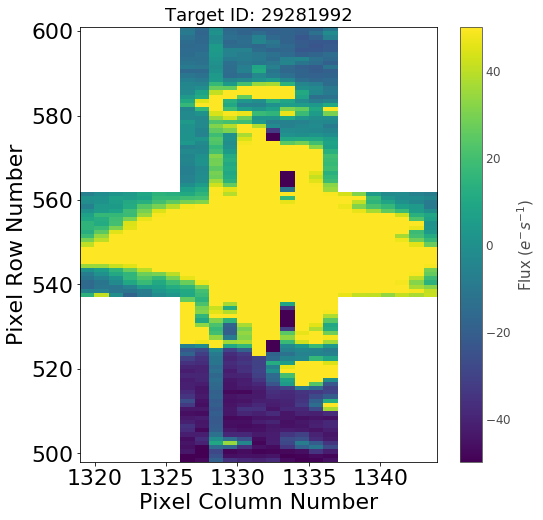

In [139]:
tpf.flux_bkg[:,:,:] = oldbks[:,:,:]
fig, ax = plt.subplots(figsize=(8,8))
tpf.plot(ax = ax, cadenceno=84061, scale='linear',vmin=-50,vmax=50,aspect='auto')
plt.show()

# fig = plt.figure(figsize=(14,9))
# plt.plot(tpf.time, tpf.flux_bkg[:,0,0],'o',alpha=0.7)
# plt.plot(tpf.time, tpf.flux_bkg[:,102,24],'o',alpha=0.7)
# plt.xlim(1340,1345)
# plt.ylim(150,250)
# plt.show()

## After

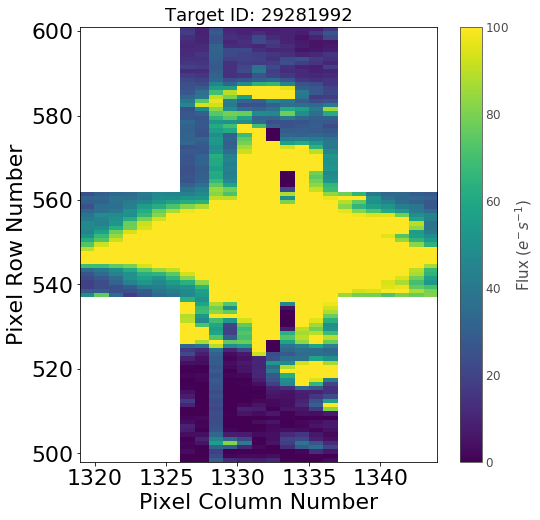

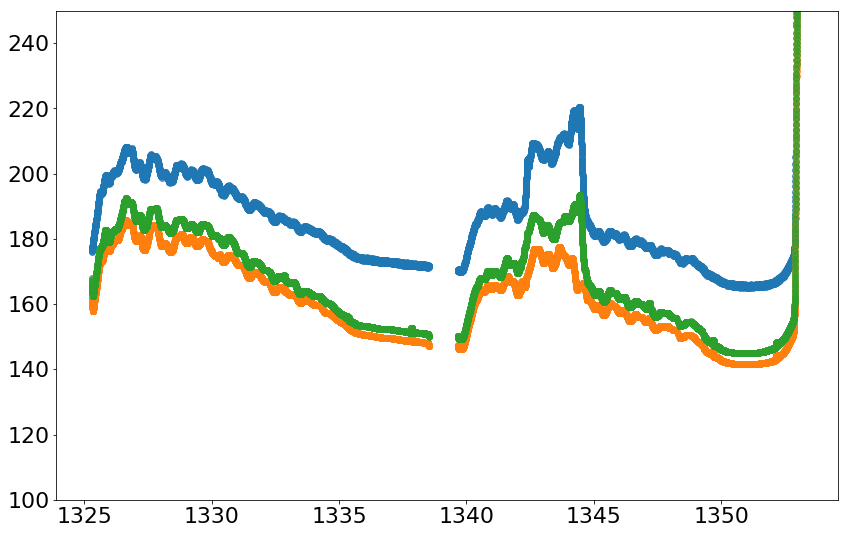

In [142]:
tpf.flux_bkg[()] = newbks[()]
fig, ax = plt.subplots(figsize=(8,8))
plot_new(tpf,newbks, ax = ax, cadenceno=84061, scale='linear',vmin=0,vmax=100,aspect='auto')
plt.show()

fig = plt.figure(figsize=(14,9))

plt.plot(tpf.time, tpf.flux_bkg[:,0,0],'o',alpha=0.7)
# plt.plot(tpf.time, tpf.flux_bkg[:,102,24],'o',alpha=0.7)
plt.plot(tpf.time, newbks[:,0,0],'o',alpha=0.7)
plt.plot(tpf.time, newbks[:,102,24],'o',alpha=0.7)
# plt.xlim(1340,1345)
plt.ylim(100,250)
plt.show()

In [55]:
print(tpf.shape)

print(s1c1ccd4['backgrounds']['0001'][()][1319:1344,498:601].shape)

cadences = s1c1ccd4['time'][()].shape[0]
print(cadences)

cut = tpfcut

# list(s1c1ccd4.keys())
# cadenceno = 4700
# hdf = s1c1ccd4
# # for i,c in enumerate(hdf['cadenceno']):
# #     print(i)
# # help(hdf['cadenceno'])
# help(hdf['backgrounds'][()])
# frame = np.argwhere(cadenceno == hdf['cadenceno'][()])[0][0]
# print(frame)
# # print(cadenceno)
# print("{:04d}".format(frame))

(18104, 103, 25)
(25, 103)
1282
(1, 25, 103)


In [13]:
def plot_ffi_bkg(hdf,ax=None, frame=0, cadenceno=None, cut=None,
         show_colorbar=True, style='lightkurve', **kwargs):
    """Plot the pixel data for a single frame (i.e. at a single time).
    The time can be specified by frame index number (`frame=0` will show the
    first frame) or absolute cadence number (`cadenceno`).
    Parameters
    ----------
    ax : matplotlib.axes._subplots.AxesSubplot
        A matplotlib axes object to plot into. If no axes is provided,
        a new one will be generated.
    frame : int
        Frame number. The default is 0, i.e. the first frame.
    cadenceno : int, optional
        Alternatively, a cadence number can be provided.
        This argument has priority over frame number.
    bkg : bool
        If True, background will be added to the pixel values.
    aperture_mask : ndarray or str
        Highlight pixels selected by aperture_mask.
    show_colorbar : bool
        Whether or not to show the colorbar
    mask_color : str
        Color to show the aperture mask
    style : str
        Path or URL to a matplotlib style file, or name of one of
        matplotlib's built-in stylesheets (e.g. 'ggplot').
        Lightkurve's custom stylesheet is used by default.
    kwargs : dict
        Keywords arguments passed to `lightkurve.utils.plot_image`.
    Returns
    -------
    ax : matplotlib.axes._subplots.AxesSubplot
        The matplotlib axes object.
    """
    if style == 'lightkurve' or style is None:
        style = MPLSTYLE
    if cadenceno is not None:
        try:
            frame = np.argwhere(cadenceno == hdf["cadenceno"][()])[0][0]
        except IndexError:
            raise ValueError("cadenceno {} is out of bounds, "
                             "must be in the range {}-{}.".format(
                                 cadenceno, hdf['cadenceno'][0], hdf['cadenceno'][-1]))
    frame = "{:04d}".format(frame)
    try:
        if cut is not None:
            if np.any(np.isfinite(hdf["backgrounds"][frame][()])):
                try:
                    pflux = hdf["backgrounds"][frame][()][cut[0]:cut[1],cut[2]:cut[3]]
                except IndexError:
                    raise ValueError("cut {} is out of bounds, must be in the"
                                     "range 0-{}".format(cut,hdf['backgrounds'][frame][()].shape))
        else:
            if np.any(np.isfinite(hdf["backgrounds"][frame][()])):
                pflux = hdf["backgrounds"][frame][()]
    except IndexError:
        raise ValueError("frame {} is out of bounds, must be in the range "
                         "0-{}.".format(frame, len(hdf["backgrounds"])))
    with plt.style.context(style):
        img_title = 'FFI background'
        if cut is not None:
            img_extent = cut
        else:
            img_extent = (0, hdf['backgrounds'][frame][()].shape[1],
                          0, hdf['backgrounds'][frame][()].shape[0])
        ax = plot_image(pflux, ax=ax, title=img_title, extent=img_extent,
                        show_colorbar=show_colorbar, **kwargs)
        ax.grid(False)
    return ax

In [116]:
def plot_new(tpf, newbkg, ax=None, frame=0, cadenceno=None, bkg=False, aperture_mask=None,
     show_colorbar=True, mask_color='pink', style='lightkurve', **kwargs):
    """Plot the pixel data for a single frame (i.e. at a single time).
    The time can be specified by frame index number (`frame=0` will show the
    first frame) or absolute cadence number (`cadenceno`).
    Parameters
    ----------
    ax : matplotlib.axes._subplots.AxesSubplot
        A matplotlib axes object to plot into. If no axes is provided,
        a new one will be generated.
    frame : int
        Frame number. The default is 0, i.e. the first frame.
    cadenceno : int, optional
        Alternatively, a cadence number can be provided.
        This argument has priority over frame number.
    bkg : bool
        If True, background will be added to the pixel values.
    aperture_mask : ndarray or str
        Highlight pixels selected by aperture_mask.
    show_colorbar : bool
        Whether or not to show the colorbar
    mask_color : str
        Color to show the aperture mask
    style : str
        Path or URL to a matplotlib style file, or name of one of
        matplotlib's built-in stylesheets (e.g. 'ggplot').
        Lightkurve's custom stylesheet is used by default.
    kwargs : dict
        Keywords arguments passed to `lightkurve.utils.plot_image`.
    Returns
    -------
    ax : matplotlib.axes._subplots.AxesSubplot
        The matplotlib axes object.
    """
    if style == 'lightkurve' or style is None:
        style = MPLSTYLE
    if cadenceno is not None:
        try:
            frame = np.argwhere(cadenceno == tpf.cadenceno)[0][0]
        except IndexError:
            raise ValueError("cadenceno {} is out of bounds, "
                             "must be in the range {}-{}.".format(
                                 cadenceno, tpf.cadenceno[0], tpf.cadenceno[-1]))
    try:
        if bkg and np.any(np.isfinite(tpf.flux_bkg[frame])):
            pflux = tpf.flux[frame] + tpf.flux_bkg[frame]
        else:
            pflux = tpf.flux[frame] + tpf.flux_bkg[frame] - newbkg[frame]
    except IndexError:
        raise ValueError("frame {} is out of bounds, must be in the range "
                         "0-{}.".format(frame, tpf.shape[0]))
    with plt.style.context(style):
        img_title = 'Target ID: {}'.format(tpf.targetid)
        img_extent = (tpf.column, tpf.column + tpf.shape[2],
                      tpf.row, tpf.row + tpf.shape[1])
        ax = plot_image(pflux, ax=ax, title=img_title, extent=img_extent,
                        show_colorbar=show_colorbar, **kwargs)
        ax.grid(False)
    if aperture_mask is not None:
        aperture_mask = tpf._parse_aperture_mask(aperture_mask)
        for i in range(tpf.shape[1]):
            for j in range(tpf.shape[2]):
                if aperture_mask[i, j]:
                    ax.add_patch(patches.Rectangle((j+tpf.column, i+tpf.row),
                                                   1, 1, color=mask_color, fill=True,
                                                   alpha=.6))
    return ax